For this assignment, you are asked to implement the convolutional neural network (CNN) architecture we
developed for MNIST in class to classify objects in the Fashion MNIST dataset. This will provide a baseline
model and predictive accuracy. From there, you will experiment with:
- Convolutional filter sizes,
- The number of features (channels) created by each convolutional layer, and
- Batch size.
  
Your task is to observe how these changes affect both the accuracy on the test set and the training time of the
model. This assignment will help you better understand the role of hyperparameters in CNNs and develop
practical skills in analyzing model performance through experimentation.
Specific Tasks
- Baseline Model Implementation:
  - Implement the CNN architecture we covered in class using PyTorch.
  - Train this model on the Fashion MNIST dataset and report the baseline accuracy on the test set.
  - Record and report the training time for the model (report all times in seconds).

- Experimentation
You should run a factorial experiment that considers all combinations of the following:
  - Filter Size - Experiment with the size of the convolutional filters used in the two convolutional layers (3x3, 5x5) and record the effect on accuracy and training time.
  - Number of Features – Experiment with the number of output channels (features) in each convolutional layer (e.g., double or halve the number of filters used in the original implementation) and record the effect on accuracy and training time.
  - Batch Size - Experiment with different batch sizes (e.g., 32, 64, 128) and record the effect on accuracy and training time.
 
- Analysis
Create a Jupyter notebook that presents results of the experimentation. In particular:
  - Present the baseline results (accuracy on the test set and computational time),
  - Present the process you used to conduct the experimentation,
  - Present and describe any impacts on accuracy and computational performance that you observe when experimenting with the various architectures.

In [1]:
import pathlib
import time
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import pandas as pd

In [2]:
#Loading testing data
test_fashion_mnist_data_filepath = pathlib.Path('fashion-mnist_test.csv')
test_fashion_mnist_data = pl.read_csv(test_fashion_mnist_data_filepath)

#Identifying the target  and features of the testing data
test_target_data = test_fashion_mnist_data.select("label").cast(pl.Int32).to_dummies()
test_feature_data = test_fashion_mnist_data.select(pl.all().exclude("label"))
test_feature_data = test_feature_data.with_columns(
    pl.all() / 255.0
)

#Loading training data
train_fashion_mnist_data_filepath = pathlib.Path('fashion-mnist_train.csv')
train_fashion_mnist_data = pl.read_csv(train_fashion_mnist_data_filepath)

#Identifying the target  and features of the training data
train_target_data = train_fashion_mnist_data.select("label").cast(pl.Int32).to_dummies()
train_feature_data = train_fashion_mnist_data.select(pl.all().exclude("label"))
train_feature_data = train_feature_data.with_columns(
    pl.all() / 255.0
)

In [3]:
#Creating a custom dataset class to get PyTorch dataloader
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [4]:
# Converting data to numpy arrays to use in the model training
X_train_full = train_feature_data.to_numpy()
y_train_full = train_target_data.to_numpy()

# Splitting the training data into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.10,
    random_state=42
)

# Converting testing data to numpy arrays
X_test = test_feature_data.to_numpy()
y_test = test_target_data.to_numpy()

# Creating Dataset objects
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

In [5]:
# Defining the CNN Model - Two convolutional layers, pooling layers, and fully connected layers: 
class SimpleCNN(nn.Module):
    #Defining the layers of the CNN:
    def __init__(self, filter_size=3, out_channels=(16, 32)):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, out_channels[0], kernel_size=filter_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=filter_size, padding=1)
        
        # Calculate the size of the output from the conv layers for the fully connected layer
        self.fc1_input_size = self._get_fc1_input_size()
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_fc1_input_size(self):
        # Calculating the number of inputs in the first fully connected layer.
        x = torch.zeros(1, 1, 28, 28)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        #Defining the sequence of operations applied to the inputs as they move through the network. 
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, self.fc1_input_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Functions for training and validation
def train_then_validate(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.unsqueeze(1))
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()

        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images.unsqueeze(1))
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.argmax(dim=1)).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    return val_accuracy, elapsed_time

Task One - Baseline Model Implementation:
-

In [7]:
#Baseline Model Training - Accuracy and computational time:
baseline_model = SimpleCNN(filter_size=3, out_channels=(16, 32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
baseline_accuracy, baseline_time = train_then_validate(baseline_model, train_loader, val_loader)

print(f"Baseline Model - Accuracy: {baseline_accuracy:.4f}, Time: {baseline_time:.2f} seconds")

Epoch 1/10, Validation Accuracy: 0.8663
Epoch 2/10, Validation Accuracy: 0.8897
Epoch 3/10, Validation Accuracy: 0.8990
Epoch 4/10, Validation Accuracy: 0.8880
Epoch 5/10, Validation Accuracy: 0.9083
Epoch 6/10, Validation Accuracy: 0.8897
Epoch 7/10, Validation Accuracy: 0.9032
Epoch 8/10, Validation Accuracy: 0.9138
Epoch 9/10, Validation Accuracy: 0.9128
Epoch 10/10, Validation Accuracy: 0.9157
Baseline Model - Accuracy: 0.9157, Time: 152.19 seconds


Task Two - Experimentation:
-

In [8]:
# Defining hyperparameter configurations
filter_sizes = [3, 5]
out_channel_configs = [(16, 32), (32, 64)]
batch_sizes = [32, 64, 128]
learning_rate = 0.001
num_epochs = 10

# To store results
results = []

# Running experiments for each combination
for filter_size in filter_sizes:
    for out_channels in out_channel_configs:
        for batch_size in batch_sizes:
            model = SimpleCNN(filter_size=filter_size, out_channels=out_channels)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)       
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Record training time
            start_time = time.time()
            
            # Training loop
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
                    images = images.unsqueeze(1) 
                    optimizer.zero_grad()
                    outputs = model(images)
                    labels = torch.argmax(labels, dim=1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            
            # Calculate training time
            training_time = time.time() - start_time
            
            # Validation loop to check accuracy
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.unsqueeze(1)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    labels = torch.argmax(labels, dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            
            results.append({
                "filter_size": filter_size,
                "out_channels": out_channels,
                "batch_size": batch_size,
                "accuracy": accuracy,
                "training_time": training_time
            })
            print(f"Filter: {filter_size}, Channels: {out_channels}, Batch Size: {batch_size} -> Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f}s")

#Results
for result in results:
    print(result)

Training Epoch 1:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/1688 [00:00<?, ?it/s]

Filter: 3, Channels: (16, 32), Batch Size: 32 -> Accuracy: 0.9223, Training Time: 153.42s


Training Epoch 1:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/844 [00:00<?, ?it/s]

Filter: 3, Channels: (16, 32), Batch Size: 64 -> Accuracy: 0.9208, Training Time: 141.81s


Training Epoch 1:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/422 [00:00<?, ?it/s]

Filter: 3, Channels: (16, 32), Batch Size: 128 -> Accuracy: 0.9157, Training Time: 132.41s


Training Epoch 1:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/1688 [00:00<?, ?it/s]

Filter: 3, Channels: (32, 64), Batch Size: 32 -> Accuracy: 0.9247, Training Time: 270.58s


Training Epoch 1:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/844 [00:00<?, ?it/s]

Filter: 3, Channels: (32, 64), Batch Size: 64 -> Accuracy: 0.9193, Training Time: 239.73s


Training Epoch 1:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/422 [00:00<?, ?it/s]

Filter: 3, Channels: (32, 64), Batch Size: 128 -> Accuracy: 0.9237, Training Time: 221.54s


Training Epoch 1:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/1688 [00:00<?, ?it/s]

Filter: 5, Channels: (16, 32), Batch Size: 32 -> Accuracy: 0.9120, Training Time: 213.19s


Training Epoch 1:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/844 [00:00<?, ?it/s]

Filter: 5, Channels: (16, 32), Batch Size: 64 -> Accuracy: 0.9162, Training Time: 181.29s


Training Epoch 1:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/422 [00:00<?, ?it/s]

Filter: 5, Channels: (16, 32), Batch Size: 128 -> Accuracy: 0.9120, Training Time: 176.91s


Training Epoch 1:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/1688 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/1688 [00:00<?, ?it/s]

Filter: 5, Channels: (32, 64), Batch Size: 32 -> Accuracy: 0.9090, Training Time: 361.21s


Training Epoch 1:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/844 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/844 [00:00<?, ?it/s]

Filter: 5, Channels: (32, 64), Batch Size: 64 -> Accuracy: 0.9130, Training Time: 339.48s


Training Epoch 1:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/422 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/422 [00:00<?, ?it/s]

Filter: 5, Channels: (32, 64), Batch Size: 128 -> Accuracy: 0.9100, Training Time: 300.56s
{'filter_size': 3, 'out_channels': (16, 32), 'batch_size': 32, 'accuracy': 0.9223333333333333, 'training_time': 153.41927886009216}
{'filter_size': 3, 'out_channels': (16, 32), 'batch_size': 64, 'accuracy': 0.9208333333333333, 'training_time': 141.80812096595764}
{'filter_size': 3, 'out_channels': (16, 32), 'batch_size': 128, 'accuracy': 0.9156666666666666, 'training_time': 132.4050257205963}
{'filter_size': 3, 'out_channels': (32, 64), 'batch_size': 32, 'accuracy': 0.9246666666666666, 'training_time': 270.57590985298157}
{'filter_size': 3, 'out_channels': (32, 64), 'batch_size': 64, 'accuracy': 0.9193333333333333, 'training_time': 239.7297658920288}
{'filter_size': 3, 'out_channels': (32, 64), 'batch_size': 128, 'accuracy': 0.9236666666666666, 'training_time': 221.54289627075195}
{'filter_size': 5, 'out_channels': (16, 32), 'batch_size': 32, 'accuracy': 0.912, 'training_time': 213.18571281433105

Task 3: Analysis 
-

Observations:
-
Filter Size (3x3 vs. 5x5)
- 3x3 Filter: Models using a 3x3 filter generally performed faster and maintained higher accuracy than those using a 5x5 filter. Using smaller filters reduce computation requirements per convolutional layer, resulting in faster training times.


Channel Depth (16-32 vs. 32-64)
- (16, 32) Channels: Models with 16 and 32 channels achieved decent accuracies with less training time. The models performed efficiently with smaller batch sizes.
- (32, 64) Channels: Increasing channel depth to (32, 64) increased the model’s capacity, resulting in an accuracy boost in some configurations and longer required training times, especially with larger filter sizes and batch sizes.

Batch Size (32, 64, 128)
- Batch Size of 32: Smaller batch sizes (32) provided the best balance between accuracy and training time. 
- Batch Size of 64: Accuracy slightly declined for most configurations with a batch size of 64, though training time was reduced compared to a batch size of 32. 
- Batch Size of 128: The largest batch size (128) consistently resulted in lower accuracy compared to smaller batch sizes across all configurations, however, the models that used a batch size of 128 were very efficient with training time.

The optimal model:
-

- Optimal architecture for highest accuracy:
  - A 3x3 filter
  - Channel Depth of 32-63
  - Batch size of 32


- Optimal architecture for efficient computational performance:
  - A 5x5 filter
  - Channel Depth of 16-32
  - Batch size of 128

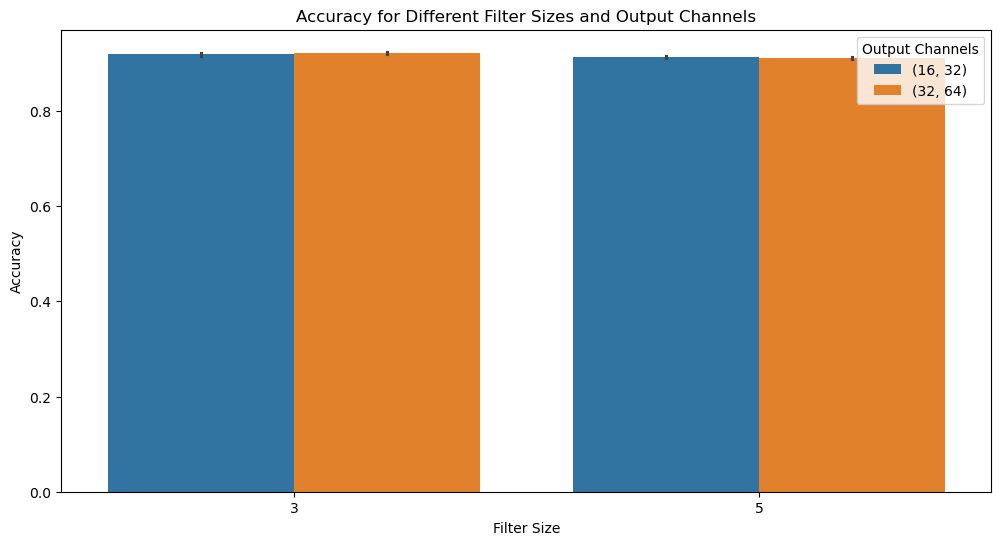

In [12]:
#Visually comparing output channels at different filter sizes:

results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='filter_size', y='accuracy', hue='out_channels')
plt.title('Accuracy for Different Filter Sizes and Output Channels')
plt.xlabel('Filter Size')
plt.ylabel('Accuracy')
plt.legend(title='Output Channels')
plt.show()

Analysis:
-
- It appears that increasing the filter size or the number of outputs didn't greatly impact the accuracy in this case, proving that the baseline model is already performing well. 

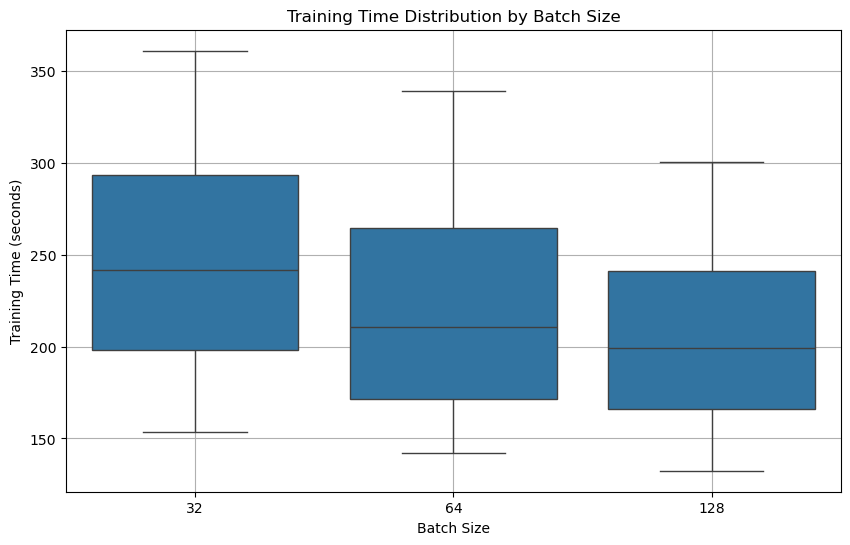

In [13]:
# Box plot to visually examin the relationship between Training Time across Batch Sizes

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='batch_size', y='training_time')
plt.title('Training Time Distribution by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.grid()
plt.show()

Analysis:
-
- Batch size 32 has the highest median training time, around 350 seconds.
- Batch size 64 has a broader interquartile range and a lower median than batch size 32. 
- Batch size 128 shows the lowesr median training time and lower spread compared to the other two batches, indicating more consistent training times.
- As the batch size increases, the training time decreases. 

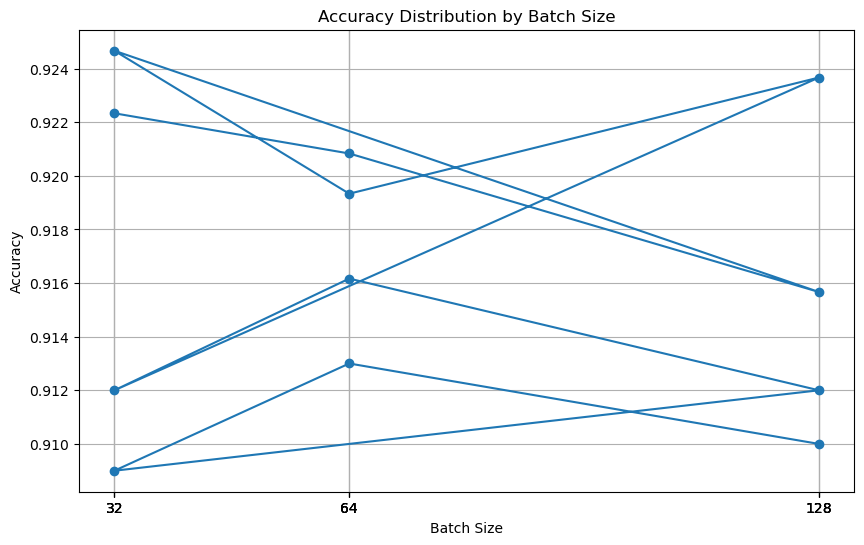

In [15]:
#Visually examine the relationship between Accuracy and Batch Size

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['accuracy'], marker='o', linestyle='-')
plt.title('Accuracy Distribution by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xticks(results_df['batch_size']) 
plt.grid()
plt.show()

Analysis:
-
- The results reveal a lack of consistency in accuracy trends relative to batch size. Although smaller batch sizes tend to achieve higher accuracy in several configurations, this is not always true. There are notable cases where batch sizes of 64 or even 128 produce the highest accuracy levels, suggesting that batch size alone is not the primary factor of model performance. Instead, the interaction between batch size and other hyperparameters likely plays a significant role in shaping accuracy outcomes. 

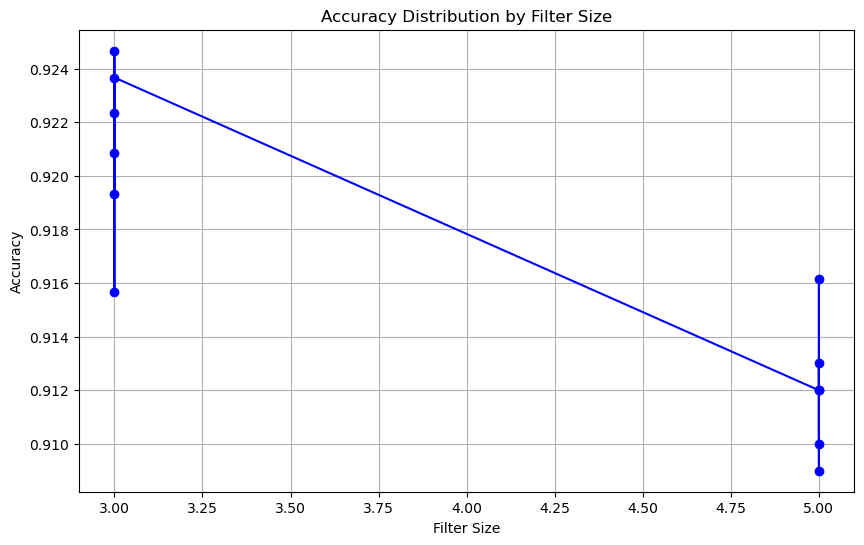

In [28]:
#Visually examine the relationship between Accuracy and Filter Size

plt.figure(figsize=(10, 6))
plt.plot(results_df['filter_size'], results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.xlabel("Filter Size")
plt.ylabel("Accuracy")
plt.title("Accuracy Distribution by Filter Size")
plt.grid(True)
plt.show()

In [26]:
average_accuracy_per_filter = results_df.groupby('filter_size')['accuracy'].mean()
print(average_accuracy_per_filter)

filter_size
3    0.921083
5    0.912028
Name: accuracy, dtype: float64


Analysis:
-
- The graph shows an inverse relationship between accuracy and filter size. A smaller filter size has the highest accuracy values, averaging around 0.92028. This suggests that the model performs better with finer filters, possibly because smaller filters capture more detailed features within the data than bigger filters.
- The vertical line extending from each data point indicate that there’s a range of accuracy values for each filter size, due to differences in other hyperparameters 

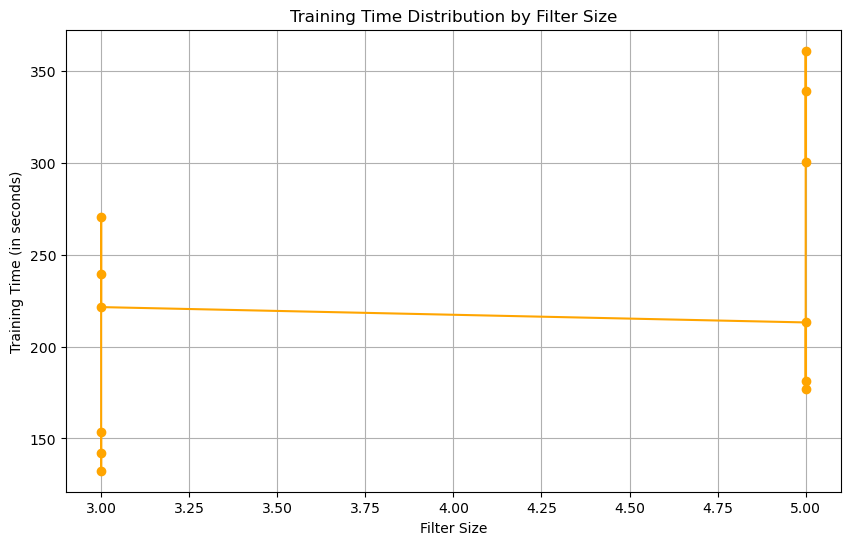

In [27]:
#Visually examine the relationship between Time Training and Filter Size

plt.figure(figsize=(10, 6))
plt.plot(results_df['filter_size'], results_df['training_time'], marker='o', color='orange', linestyle='-')
plt.title('Training Time Distribution by Filter Size')
plt.xlabel('Filter Size')
plt.ylabel('Training Time (in seconds)')
plt.grid(True)
plt.show()

In [31]:
average_accuracy_per_filter = results_df.groupby('filter_size')['training_time'].mean()
print(average_accuracy_per_filter)

filter_size
3    193.246833
5    262.104761
Name: training_time, dtype: float64


Analysis:
-
- The trend is mostly flat with a slight downward movement, indicating no significant correlation.
- Although training time is longer when using a filter size of 5x5 compared to a filter size of 3x3, this graph suggests that filter size does not significantly impact training time in this case, or the impact is minimal relative to other factors.